# In this notebook we analyze the results from get_random_data.jl of rho(epsilon)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from typing import Dict

sns.set_theme(style="darkgrid", palette="deep")

In [6]:
# Data params

# L_vals = [8000, 10_000, 12_000, 14_000, 16_000, 18_000, 20_000]
L_vals = [8000]
epsilon_vals = sorted([round(0.01 * i, ndigits=4) for i in range(0, 101)])

time_prefact = 200

num_initial_conds = 500
initial_state_prob = 0.5



In [7]:

avrage_rho_per_ep : Dict[int, Dict[float, float]] = {}
sem_rho_per_ep : Dict[int, Dict[float, float]] = {}

for L_val in L_vals:
    avrage_rho_per_ep[L_val] = {}
    sem_rho_per_ep[L_val] = {}

    parent_path = f"data/time_rand/rho_per_epsilon/IC1/L{L_val}"

    for epsilon_val in epsilon_vals:

        sample_filepath = f"{parent_path}/IC1_L{L_val}_epsilon{str(epsilon_val).replace("0.", "0p").replace("1.", "0p")}.csv"
        
        sample_df = pd.read_csv(sample_filepath)

        avrage_rho_per_ep[L_val][epsilon_val] = sample_df["rho"].mean()
        sem_rho_per_ep[L_val][epsilon_val] = sample_df["rho"].sem()
        

In [8]:
avrage_rho_per_ep[8000].keys()

dict_keys([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])

# Basic plot of 1-rho per epsilon

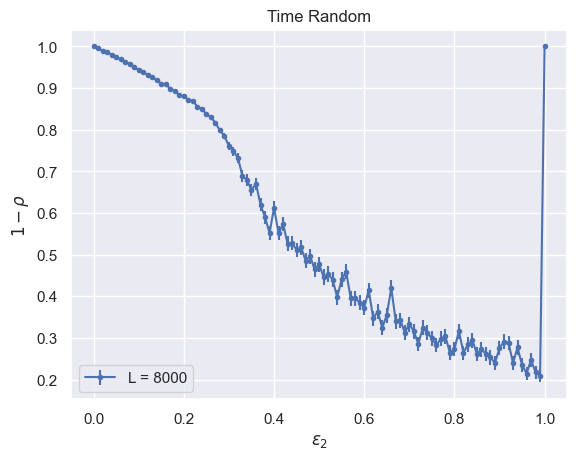

In [13]:

for L in L_vals:
    epsilon_vals = sorted(list(avrage_rho_per_ep[L].keys()))
    plt.errorbar(
        epsilon_vals, 
        [1-avrage_rho_per_ep[L][epsilon_val] for epsilon_val in epsilon_vals], 
        yerr=[sem_rho_per_ep[L][epsilon_val] for epsilon_val in epsilon_vals],
        label = f"L = {L}",
        fmt='-o',  
        markersize=3
        )
plt.title("Time Random")
plt.xlabel(r"$\epsilon_2$")
plt.ylabel(r"$1 - \rho$")
plt.legend()

plt.savefig("figs/timerandom.png")
plt.show()


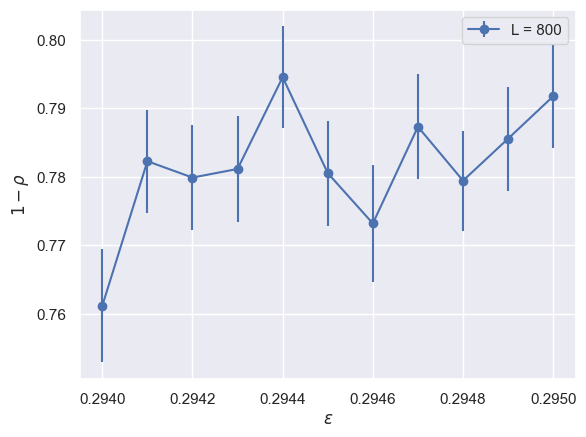

In [ ]:
trans_window = (0.294, 0.295)

for L in L_vals:
    epsilon_vals = sorted([epsilon for epsilon in avrage_rho_per_ep[L].keys() if trans_window[0] <= epsilon <= trans_window[1]])
    plt.errorbar(
        epsilon_vals, 
        [1-avrage_rho_per_ep[L][epsilon_val] for epsilon_val in epsilon_vals], 
        yerr=[sem_rho_per_ep[L][epsilon_val] for epsilon_val in epsilon_vals],
        label = f"L = {L}",
        fmt='-o',  
        # markersize=2
        )

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$1 - \rho$")
plt.legend()
plt.show()
